In [2]:
%matplotlib inline
import os
from subprocess import call
from tqdm import tqdm_notebook as tqdm

import xarray as xr
import numpy as np
import cftime
import dask

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import  matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cmocean

import geotools as gt
import plottools as pt
import project as P

USER = os.environ['USER']

In [3]:
from dask.distributed import Client
from dask_jobqueue import PBSCluster

# Lots of arguments to this command are set in ~/.config/dask/jobqueue.yaml
cluster = PBSCluster(queue='regular',
                     cores = 36,
                     processes = 9,
                     memory = '100GB',                     
                     project = 'NCGD0033',
                     walltime = '04:00:00',
                     local_directory=f'/glade/scratch/{USER}/dask-tmp')
client = Client(cluster)

In [4]:
Nnodes = 4
cluster.scale(9*Nnodes)

## Load annual mean datasets

In [5]:
clobber = False
npac_isel = {'nlat':slice(187,331),'nlon':slice(137,276)}
variables = ['O2','SALT','TEMP','SSH']

### read z-coordinate annual mean data

In [6]:
dsz = P.annmean_collection(base_dataset = 'FOSI_monthly',
                           variables = variables+['PD'], 
                           isel_name = 'npac',
                           isel = npac_isel,
                           clobber = clobber)

#-- convert to sigma-theta units
dsz.PD.values = (dsz.PD - 1.)*1000.

reading /glade/scratch/mclong/calcs/o2-prediction/FOSI_monthly.ann.npac.O2.zarr
reading /glade/scratch/mclong/calcs/o2-prediction/FOSI_monthly.ann.npac.SALT.zarr
reading /glade/scratch/mclong/calcs/o2-prediction/FOSI_monthly.ann.npac.TEMP.zarr
reading /glade/scratch/mclong/calcs/o2-prediction/FOSI_monthly.ann.npac.SSH.zarr
reading /glade/scratch/mclong/calcs/o2-prediction/FOSI_monthly.ann.npac.PD.zarr


## compute anomalies wrt long-term mean

In [7]:
dsz_clm = dsz.drop([v for v,da in dsz.variables.items() if 'time' not in da.dims]).mean('time').compute()
dsza = dsz - dsz_clm

/glade/work/mclong/miniconda3/envs/py3/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


## compute EOFs to assess basin-scale variability

In [8]:
from eofs.xarray import Eof

can I reproduce the observed PDO computed on the basis of SST?

In [9]:
pcs = xr.Dataset()

In [10]:
#-- use data only above 20°N
wgts = dsz.TAREA.where(dsz.TLAT>20).fillna(0.)
solver = Eof(dsza.TEMP.isel(z_t=0),weights=wgts)
pcs['SST'] = solver.pcs(npcs=3,pcscaling=1) # PCs scaled to unit-variance
eofs = solver.eofs(neofs=3,eofscaling=1)
variance_fractions = solver.varianceFraction()
print(variance_fractions.values[0:3])

compute (approximate) annual mean PDO from obs

In [11]:
pdo = P.load_pdo(year_range=(1948,2015)).PDO.groupby('time.year').mean('time')

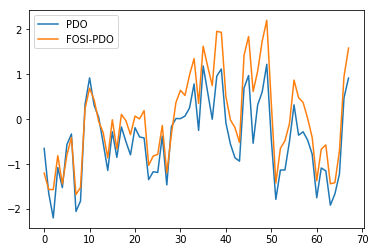

In [13]:
plt.plot(pdo,label='PDO')
plt.plot(pcs.SST.isel(mode=0),label='FOSI-PDO')
plt.legend()

What does SSH variability look like?

In [28]:
wgts = dsz.TAREA #.where(dsz.TLAT>20).fillna(0.)
solver = Eof(dsza.SSH,weights=wgts)
pcs['SSH'] = solver.pcs(npcs=3,pcscaling=1).compute() # PCs scaled to unit-variance
eofs = solver.eofs(neofs=3,eofscaling=1)
variance_fractions = solver.varianceFraction()
print(variance_fractions.values[0:3])

[0.3207252  0.18318272 0.09492584]


In [36]:
wgts = dsz.TAREA.where(dsz.TLAT>20).fillna(0.)
solver = Eof(dsza.O2.sel(z_t=200e2,method='nearest'),weights=wgts)
pcs['O2_200m'] = solver.pcs(npcs=3,pcscaling=1).compute() # PCs scaled to unit-variance
eofs = solver.eofs(neofs=3,eofscaling=1)
variance_fractions = solver.varianceFraction()
print(variance_fractions.values[0:3])

[0.24982017 0.13314272 0.09349288]


## define a function to enable regressing fields on PCs

In [37]:
def regress(x,pc_varname,mode=0):
    pf = np.polyfit(pcs[pc_varname].isel(mode=mode),x,1)
    return xr.DataArray(pf[0])

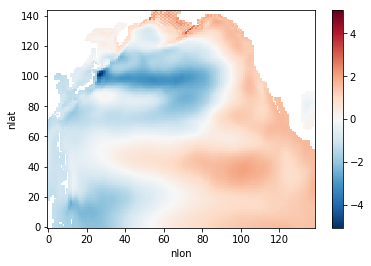

In [33]:
x = dsza.SSH.stack({'lateral_dims':['nlat','nlon']}).compute()
r = x.groupby('lateral_dims').apply(regress,pc_varname='SST',mode=0).unstack('lateral_dims')
r.plot()

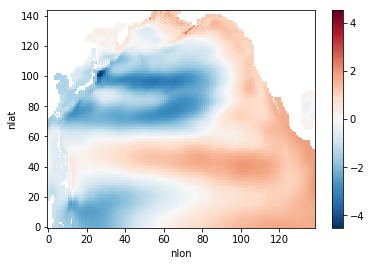

In [35]:
x = dsza.SSH.stack({'lateral_dims':['nlat','nlon']}).compute()
r = x.groupby('lateral_dims').apply(regress,pc_varname='SSH',mode=1).unstack('lateral_dims')
r.plot()

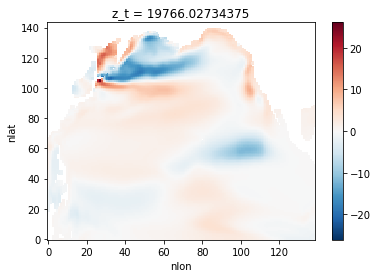

In [38]:
x = dsza.O2.sel(z_t=200e2,method='nearest').stack({'lateral_dims':['nlat','nlon']}).compute()
r = x.groupby('lateral_dims').apply(regress,pc_varname='O2_200m',mode=0).unstack('lateral_dims')
r.plot()